In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
from itertools import compress
import calfews_src
# from read_hdf5_output import get_results_sensitivity_number
from calfews_src import *
from calfews_src.visualizer import Visualizer
from calfews_src.util import *
import seaborn as sns

<AxesSubplot:>

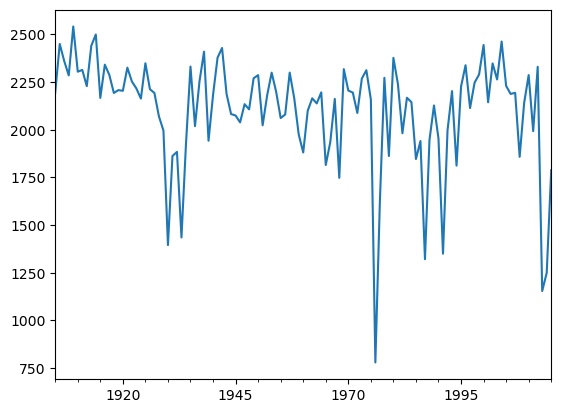

In [150]:
output_folder = "results/110_year/"
# output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
daily_pump_data = datDaily.loc[:,['delta_HRO_pump', 'delta_TRP_pump']]
daily_pump_data['total_pump'] = daily_pump_data['delta_HRO_pump'] 
# + daily_pump_data['delta_TRP_pump'] # only get water from SWP (HRO)
yearly_pump_data = daily_pump_data.resample('AS-OCT').sum()
yearly_pump_data = yearly_pump_data['total_pump']
yearly_pump_data.plot()
# monthly_pump_data['total_pump']

<AxesSubplot:>

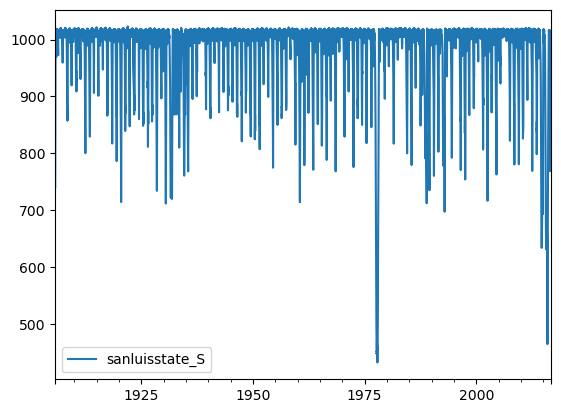

In [151]:
datDaily[['sanluisstate_S']].plot()

<AxesSubplot:>

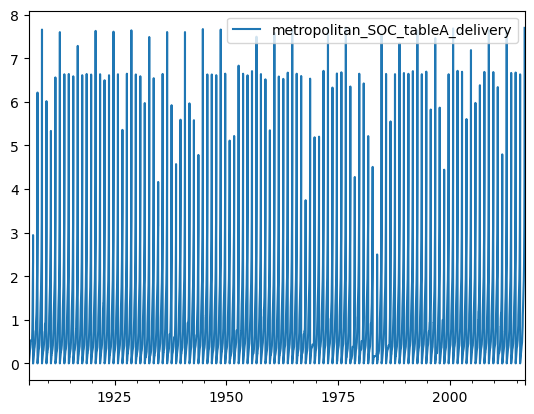

In [154]:
datDaily[['metropolitan_SOC_tableA_delivery']].plot()

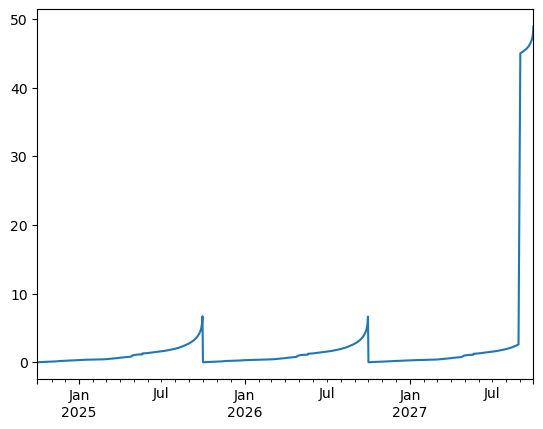

metropolitan_SOC_tableA_delivery


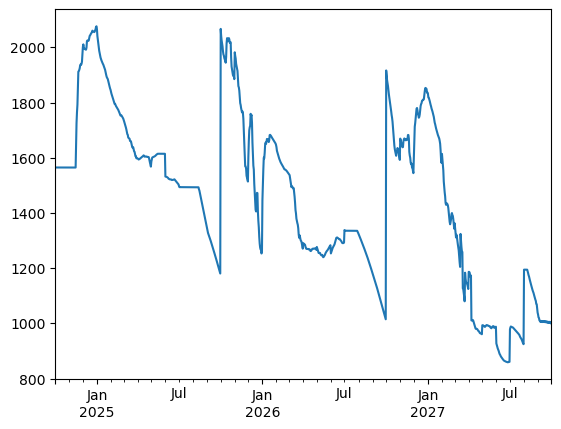

metropolitan_SOC_tableA_projected


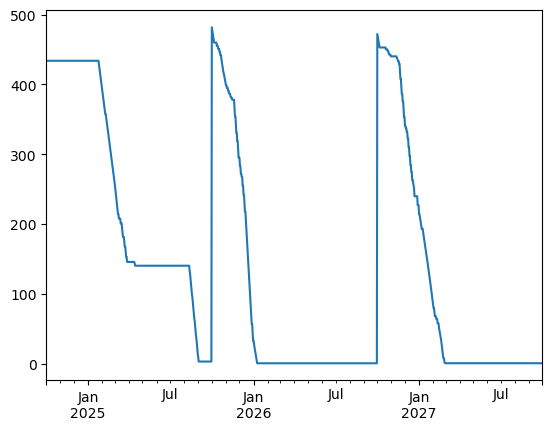

metropolitan_SOC_tableA_carryover


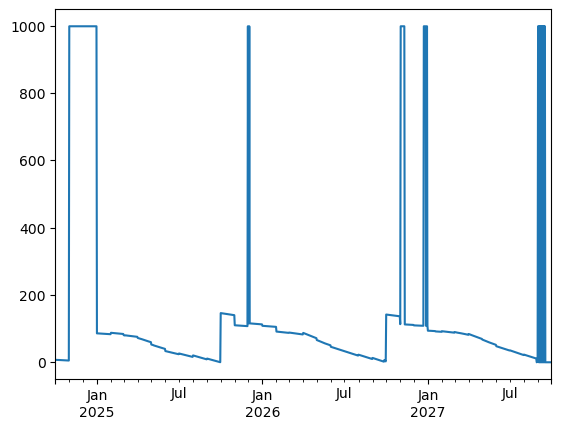

metropolitan_SOC_tableA_dynamic_recharge_cap


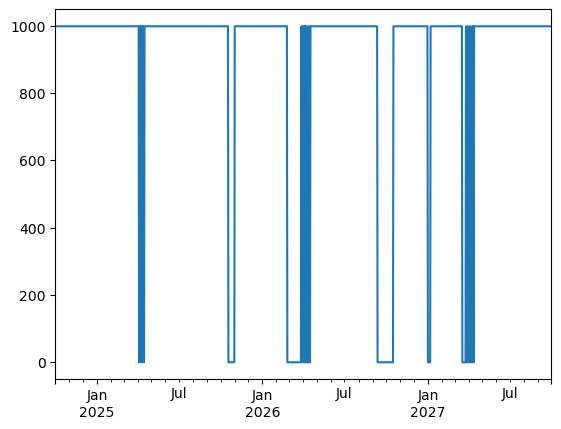

metropolitan_SOC_cvc_dynamic_recharge_cap


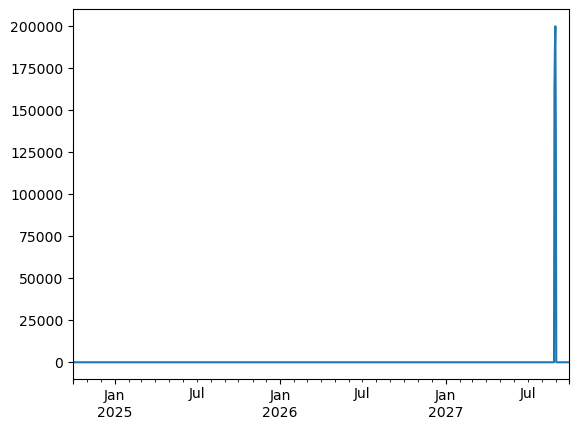

metropolitan_SOC_irr_demand


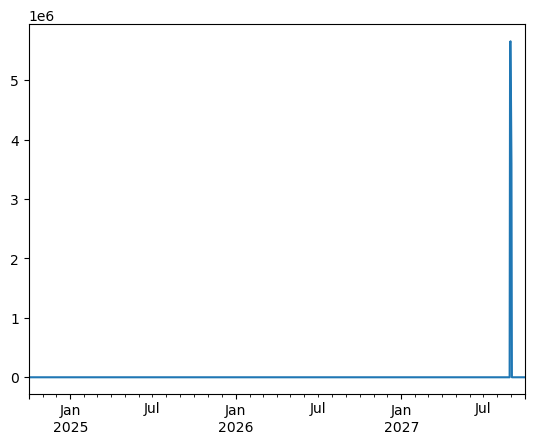

metropolitan_SOC_tot_demand


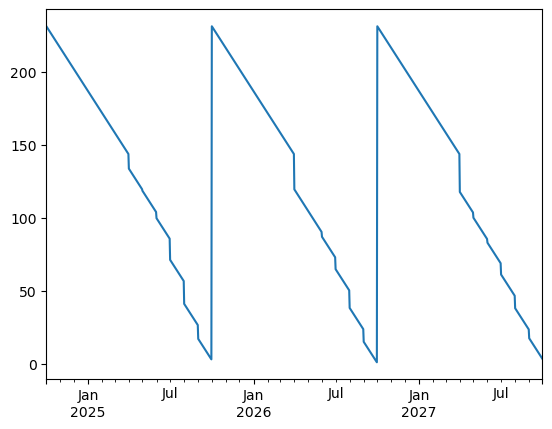

metropolitan_SOC_dynamic_recovery_cap


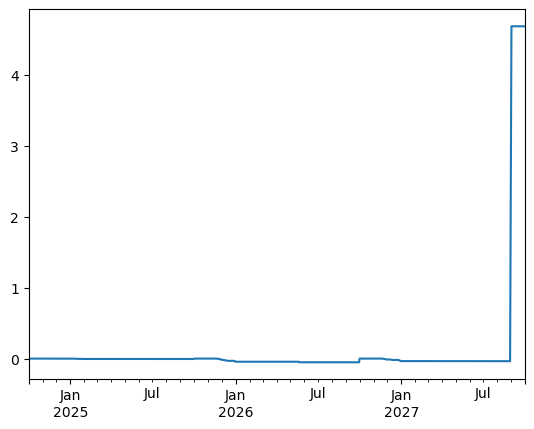

metropolitan_SOC_tableA_paper


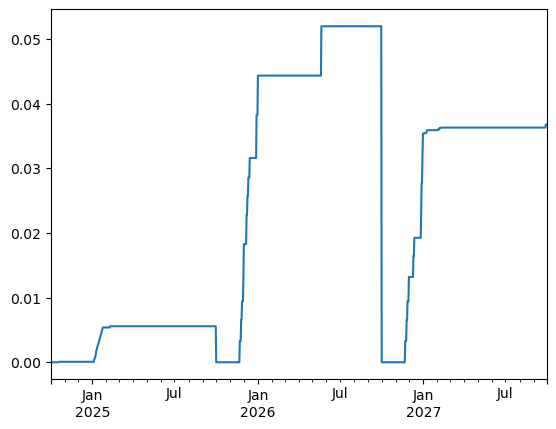

metropolitan_SOC_exchanged_SW


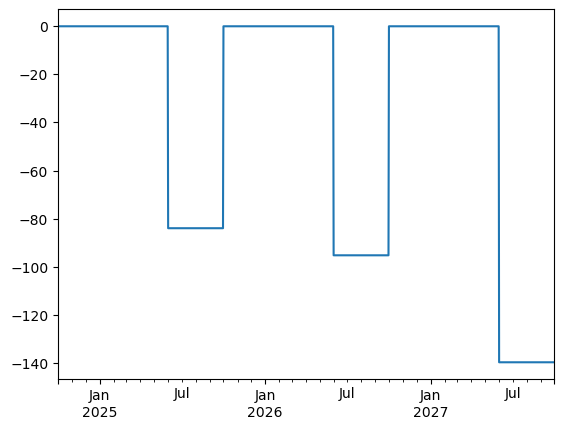

metropolitan_SOC_tableA_turnback


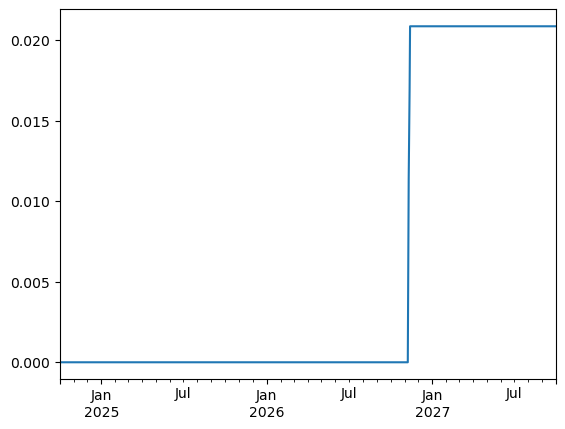

metropolitan_SOC_kaweah_flood


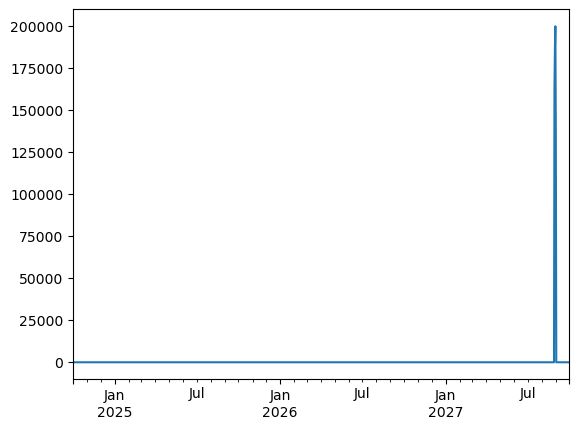

metropolitan_SOC_pumping


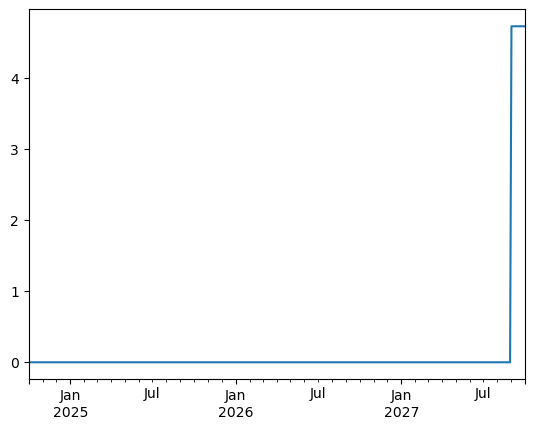

metropolitan_SOC_exchanged_GW


In [26]:
met_cols = [col for col in datDaily.columns if 'metropolitan' in col]
# print(list(df.columns))
for x in met_cols:
    datDaily[x].plot()
    plt.show()
    print(x)
# met_cols

<AxesSubplot:>

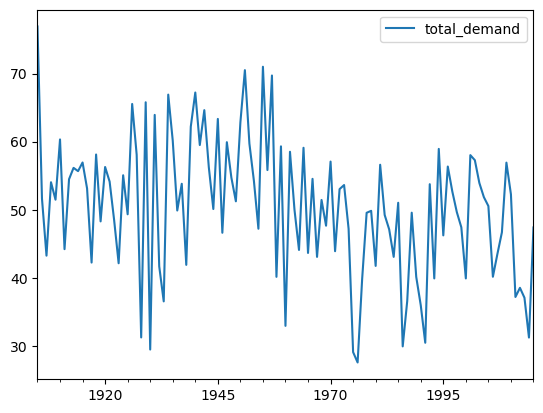

In [111]:
yearly_demand_1 = datDaily[['wonderful_LHL_tableA_delivery']].resample('AS-OCT').max()
yearly_demand_2 = datDaily[['losthills_tableA_delivery']].resample('AS-OCT').max()
total= np.asarray(yearly_demand_1) + np.asarray(yearly_demand_2)
total = pd.DataFrame(total, index=yearly_demand_1.index, columns=['total_demand'])
total.plot()

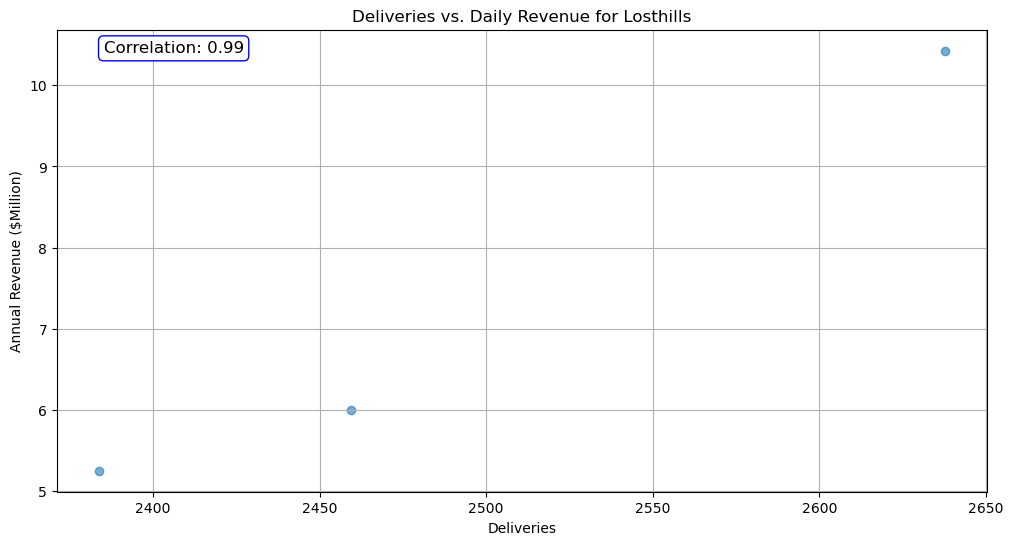

In [25]:
#######basis risk for lost Hills irrigation district###########################
###############################################################################
output_folder = "results/1_2024/"
# output_folder = "results/110_year/"
# output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
daily_pump_data = datDaily.loc[:,['delta_HRO_pump', 'delta_TRP_pump']]
daily_pump_data['total_pump'] = daily_pump_data['delta_HRO_pump']   # only get water from SWP (HRO)
yearly_pump_data = daily_pump_data.resample('AS-OCT').sum()
yearly_pump_data = yearly_pump_data['total_pump']

revenue_file = 'calfews_src/postprocess/losthills_daily_revenue_syn_1_2024.csv'
# revenue_file = 'calfews_src/postprocess/losthills_daily_revenue_110.csv'
# revenue_file = 'calfews_src/postprocess/losthills_daily_revenue.csv'
losthills_daily_revenue = pd.read_csv(revenue_file, index_col=0, parse_dates=True)
losthills_Y_revenue = losthills_daily_revenue.resample('AS-OCT').last()
# losthills_Y_revenue
aligned_data = losthills_Y_revenue.join(yearly_pump_data, how='inner')
x = aligned_data['total_pump']
y = aligned_data.iloc[:, 0]

# Calculate the linear fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.6,)
# plt.plot(x, line, 'r-', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
plt.title(f"Deliveries vs. Daily Revenue for Losthills")
plt.xlabel("Deliveries")
plt.ylabel("Annual Revenue ($Million)")
plt.grid(True)
# plt.legend()


#use numpy to calculate the correlation coefficient as a visual indicator
corr_coef = np.corrcoef(x, y)[0, 1]
plt.annotate(f"Correlation: {corr_coef:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.show()

In [20]:
daily_pump_data

,delta_HRO_pump,delta_TRP_pump,total_pump
1905-10-01,13.249587,8.528926,13.249587
1905-10-02,13.249587,8.528926,13.249587
1905-10-03,13.249587,8.528926,13.249587
1905-10-04,13.249587,8.528926,13.249587
1905-10-05,13.249587,8.528926,13.249587
...,...,...,...
2016-09-26,4.440029,8.528926,4.440029
2016-09-27,4.717876,8.528926,4.717876
2016-09-28,4.909874,8.528926,4.909874
2016-09-29,5.466727,8.528926,5.466727


(array([ 4.,  3.,  1.,  5.,  2., 10.,  8.,  6., 10., 11., 13., 12.,  9.,
         4.,  4.,  4.,  1.,  3.,  0.,  1.]),
 array([3.49347461, 3.80618797, 4.11890133, 4.43161469, 4.74432804,
        5.0570414 , 5.36975476, 5.68246811, 5.99518147, 6.30789483,
        6.62060819, 6.93332154, 7.2460349 , 7.55874826, 7.87146161,
        8.18417497, 8.49688833, 8.80960169, 9.12231504, 9.4350284 ,
        9.74774176]),
 <BarContainer object of 20 artists>)

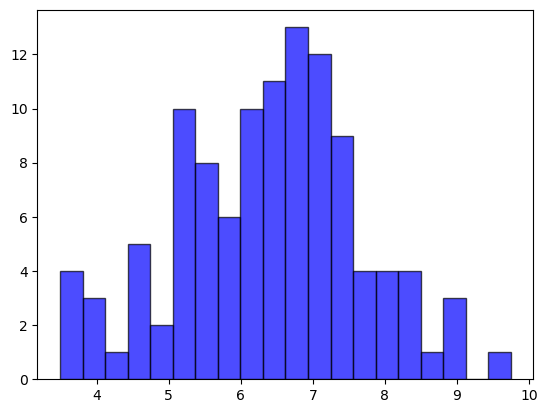

In [129]:
plt.hist(losthills_Y_revenue['0'], bins=20, color='blue', edgecolor='black', alpha=0.7)

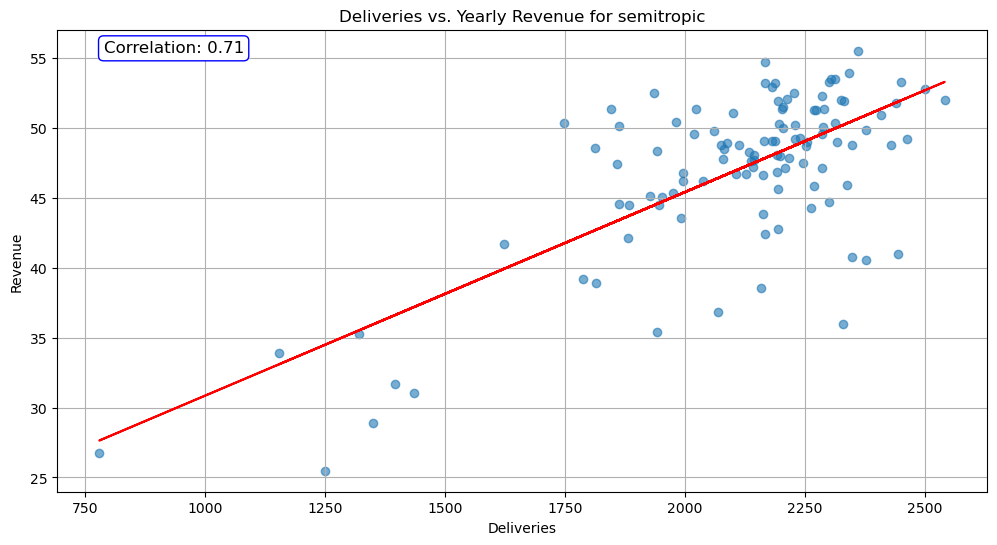

In [22]:
revenue_file = 'calfews_src/postprocess/semitropic_daily_revenue_110.csv'
semitropic_daily_revenue = pd.read_csv(revenue_file, index_col=0, parse_dates=True)
semitropic_Y_revenue = semitropic_daily_revenue.resample('AS-OCT').last()

aligned_data = semitropic_Y_revenue.join(yearly_pump_data, how='inner')
x = aligned_data['total_pump']
y = aligned_data.iloc[:, 0]

# Calculate the linear fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.6,)
plt.plot(x, line, 'r-', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
plt.title(f"Deliveries vs. Yearly Revenue for semitropic")
plt.xlabel("Deliveries")
plt.ylabel("Revenue")
plt.grid(True)
# plt.legend()


# You can use numpy to calculate the correlation coefficient as a visual indicator
corr_coef = np.corrcoef(x, y)[0, 1]
plt.annotate(f"Correlation: {corr_coef:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.show()

(array([ 1.,  0.,  0.,  0.,  2.,  2.,  0.,  2.,  2.,  1.,  1.,  3.,  4.,
         6., 10., 16., 26., 23.,  9.,  3.]),
 array([1730.06768457, 1913.27309408, 2096.47850358, 2279.68391308,
        2462.88932259, 2646.09473209, 2829.30014159, 3012.5055511 ,
        3195.7109606 , 3378.9163701 , 3562.1217796 , 3745.32718911,
        3928.53259861, 4111.73800811, 4294.94341762, 4478.14882712,
        4661.35423662, 4844.55964613, 5027.76505563, 5210.97046513,
        5394.17587463]),
 <BarContainer object of 20 artists>)

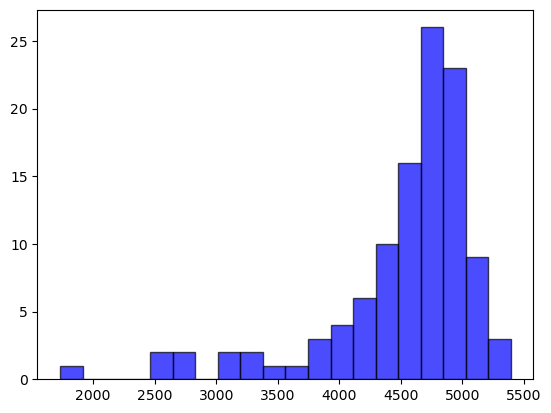

In [133]:
plt.hist(aligned_data['total_pump'], bins=20, color='blue', edgecolor='black', alpha=0.7)